# Thematic Analysis

## Data loading

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re, string
#import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import demoji

In [262]:

import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
#import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [263]:
# Read the Excel file
tweet_df = pd.read_csv('StandWithUkraineManual.csv')
tweet_df
tweet_df.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,Searh,Unnamed: 29,manual_label
0,snscrape.modules.twitter.Tweet,https://twitter.com/seriouschris90/status/1500...,2022-03-05 23:59:51+00:00,@RitchieTorres Please get it done!! Arm Ukrain...,@RitchieTorres Please get it done!! Arm Ukrain...,1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,['StandwithUkraine'],NaN,StandWithUkraine,NaN,standwithukraine'
1,snscrape.modules.twitter.Tweet,https://twitter.com/dyingBreath/status/1500259...,2022-03-05 23:59:49+00:00,"Maybe it's the end but it never is, stay stron...","Maybe it's the end but it never is, stay stron...",1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,3,1,...,NaN,NaN,NaN,NaN,NaN,"['StandWithUkraine', 'PrayingForUkraine']",NaN,StandWithUkraine,NaN,standwithukraine'
2,snscrape.modules.twitter.Tweet,https://twitter.com/happytoday_777/status/1500...,2022-03-05 23:59:40+00:00,2年ぶりに東京マラソンやるんだね！参加の皆さん楽しんで下さいね。小池都知事の服がウクライナカ...,2年ぶりに東京マラソンやるんだね！参加の皆さん楽しんで下さいね。小池都知事の服がウクライナカ...,1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,1,2,...,NaN,NaN,NaN,NaN,NaN,"['東京マラソン', 'NoWar', 'StandWithUkraine', 'нетво...",NaN,StandWithUkraine,NaN,NaN
3,snscrape.modules.twitter.Tweet,https://twitter.com/Aaron25029105/status/15002...,2022-03-05 23:59:33+00:00,@chipfranklin I Stand With Ukraine 🇺🇦🇺🇲🇺🇦🇺🇲🇺🇦🇺...,@chipfranklin I Stand With Ukraine 🇺🇦🇺🇲🇺🇦🇺🇲🇺🇦🇺...,1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,StandWithUkraine,NaN,standwithukraine'
4,snscrape.modules.twitter.Tweet,https://twitter.com/loveamaninasuit/status/150...,2022-03-05 23:59:29+00:00,Amor d'Água Fresca by Rita Redshoes in Ukraine...,Amor d'Água Fresca by Rita Redshoes in Ukraine...,1.500000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,2,2,...,NaN,NaN,NaN,NaN,NaN,['StandWithUkraine'],NaN,StandWithUkraine,NaN,standwithukraine'


In [264]:
tweet_df.columns

Index(['_type', 'url', 'date', 'content', 'renderedContent', 'id', 'user',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'media', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags', 'Searh', 'Unnamed: 29',
       'manual_label'],
      dtype='object')

## Data Pre-Processing

In [265]:
#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')#remove emoji

In [266]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [267]:
import re

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split(r'#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split(r'#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

In [268]:
#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

In [269]:
tweet_df['content'].dropna(inplace=True)
tweet_df['text_clean'] = tweet_df['content'].apply(lambda x: strip_all_entities(x))
tweet_df['text_clean'] = tweet_df['text_clean'].apply(lambda x: clean_hashtags(x))
tweet_df['text_clean'] = tweet_df['text_clean'].apply(lambda x: filter_chars(x))
tweet_df['text_clean'] = tweet_df['text_clean'].apply(lambda x: remove_mult_spaces(x))

In [270]:
train_data, test_data = train_test_split(tweet_df, test_size=0.2, random_state=42)

In [271]:
train_data[['content','text_clean']]

,content,text_clean
56,【音韓】ジン（BTS（防弾少年団））に投票完了！現在の得票数:12805票\n人気投票はこち...,bts12805 spotify4800 yoursjin yours jin jin se...
227,@e2dot7182818284 @America1Scotty @TiaRees9 Ok ...,ok you boring bitch stand with ukraine go to p...
280,Brittney Griner was arrested in Moscow is this...,brittney griner was arrested in moscow is this...
486,Gotta stand with Ukraine though right? All tho...,gotta stand with ukraine though right all thos...
220,🇺🇦\nUkraine \n#RussiaUkraineWar\n#StopWarInUkr...,ukraine russiaukrainewar stopwarinukraine kyiv...
...,...,...
106,#standwithUkraine https://t.co/Ir3Daiut11,standwithukraine
270,The amazing people at @MemeNFTOfficial is curr...,the amazing people at is currently having a fu...
348,@ZelenskyyUa @naftalibennett I stand with Ukra...,i stand with ukraine
435,Some photos from today’s Seattle Ukraine March...,some photos from todays seattle ukraine march ...


In [272]:
import nltk
from nltk.tokenize import word_tokenize
train_data['tokenized'] = [word_tokenize(entry) for entry in train_data['text_clean']]

In [273]:
train_data['tokenized']

56     [bts12805, spotify4800, yoursjin, yours, jin, ...
227    [ok, you, boring, bitch, stand, with, ukraine,...
280    [brittney, griner, was, arrested, in, moscow, ...
486    [got, ta, stand, with, ukraine, though, right,...
220    [ukraine, russiaukrainewar, stopwarinukraine, ...
                             ...                        
106                                   [standwithukraine]
270    [the, amazing, people, at, is, currently, havi...
348                            [i, stand, with, ukraine]
435    [some, photos, from, todays, seattle, ukraine,...
102               [icc, karimaakhanqc, standwithukraine]
Name: tokenized, Length: 399, dtype: object

In [274]:
print(train_data.shape)

(399, 33)


## BerTopic Modelling

In [164]:
from bertopic import BERTopic

# Train BERTopic model and calculate coherence
bertopic_model = BERTopic()


In [165]:
text_data = tweet_df['text_clean'].tolist() 

In [166]:
bertopic_model.fit(text_data) 

In [167]:
bertopic_topics, _ = bertopic_model.fit_transform(text_data)  

In [122]:
# Retrieve topic keywords from the BERTopic model
bertopic_topic_keywords = bertopic_model.get_topics()

In [123]:
topic_labels = bertopic_model.generate_topic_labels(nr_words=5, separator=", ")
type(topic_labels)
topic_labels

['-1, standwithukraine, mlb, noflyzone, it, is',
 '0, ukraine, the, with, to, stand',
 '1, standwithukraine, you, is, standwithbiden, defeatthegop2022',
 '2, playing, video, standwithukraine, now, is',
 '3, mastercard, visa, operations, russia, in',
 '4, nowar, standwithukraine, youtube, todayweareallukraine, nowplaying']

In [124]:
words_lists=[]
integers = []
for topic in topic_labels:
    parts=topic.split(', ')
    # Convert the first part to an integer and append to the integers list
    integers.append(int(parts[0]))
    
    # Append the rest of the parts (the words) to the words_list
    words_lists.append(parts[1:])

# Print the separated integers and words
print("Integers:", integers)
print("Words lists:", words_lists)
type(words_lists)

Integers: [-1, 0, 1, 2, 3, 4]
Words lists: [['standwithukraine', 'mlb', 'noflyzone', 'it', 'is'], ['ukraine', 'the', 'with', 'to', 'stand'], ['standwithukraine', 'you', 'is', 'standwithbiden', 'defeatthegop2022'], ['playing', 'video', 'standwithukraine', 'now', 'is'], ['mastercard', 'visa', 'operations', 'russia', 'in'], ['nowar', 'standwithukraine', 'youtube', 'todayweareallukraine', 'nowplaying']]


list

In [126]:
words_lists=[]
integers = []
for topic in topic_labels:
    parts=topic.split(', ')
    # Convert the first part to an integer and append to the integers list
    integers.append(int(parts[0]))
    
    # Append each word as a separate list to the words_list
    words_lists.append([[word] for word in parts[1:]])

# Print the separated integers and words
print("Integers:", integers)
print("Words lists:", words_lists)


Integers: [-1, 0, 1, 2, 3, 4]
Words lists: [[['standwithukraine'], ['mlb'], ['noflyzone'], ['it'], ['is']], [['ukraine'], ['the'], ['with'], ['to'], ['stand']], [['standwithukraine'], ['you'], ['is'], ['standwithbiden'], ['defeatthegop2022']], [['playing'], ['video'], ['standwithukraine'], ['now'], ['is']], [['mastercard'], ['visa'], ['operations'], ['russia'], ['in']], [['nowar'], ['standwithukraine'], ['youtube'], ['todayweareallukraine'], ['nowplaying']]]


In [127]:
print("Words lists:", words_lists)

Words lists: [[['standwithukraine'], ['mlb'], ['noflyzone'], ['it'], ['is']], [['ukraine'], ['the'], ['with'], ['to'], ['stand']], [['standwithukraine'], ['you'], ['is'], ['standwithbiden'], ['defeatthegop2022']], [['playing'], ['video'], ['standwithukraine'], ['now'], ['is']], [['mastercard'], ['visa'], ['operations'], ['russia'], ['in']], [['nowar'], ['standwithukraine'], ['youtube'], ['todayweareallukraine'], ['nowplaying']]]


In [128]:
data_dict = {}
for topic in topic_labels:
    parts = topic.split(', ')
    key = int(parts[0])
    words = parts[1:]
    data_dict[key] = [[word] for word in words]

# Print the dictionary
for key, value in data_dict.items():
    print(key, value)


-1 [['standwithukraine'], ['mlb'], ['noflyzone'], ['it'], ['is']]
0 [['ukraine'], ['the'], ['with'], ['to'], ['stand']]
1 [['standwithukraine'], ['you'], ['is'], ['standwithbiden'], ['defeatthegop2022']]
2 [['playing'], ['video'], ['standwithukraine'], ['now'], ['is']]
3 [['mastercard'], ['visa'], ['operations'], ['russia'], ['in']]
4 [['nowar'], ['standwithukraine'], ['youtube'], ['todayweareallukraine'], ['nowplaying']]


In [275]:
manual_labels = tweet_df['manual_label'].apply(lambda x: [x]).tolist()

In [276]:
formatted_manual_labels = []
for labels in manual_labels:
    if isinstance(labels[0], str):
        formatted_labels = [label.strip("[]'") for label in labels[0].split(', ')]
        formatted_manual_labels.append(formatted_labels)
    else:
        formatted_manual_labels.append([])
        
print("Formatted Manual Labels:", formatted_manual_labels)


Formatted Manual Labels: [['standwithukraine'], ['standwithukraine'], [], ['standwithukraine'], ['standwithukraine'], ['standwithukraine'], ['standwithukraine'], ['stopwarinukraine'], ['standwithukraine'], ['stopputin'], ['medvedevRussiae'], [], ['medvedevRussiae'], ['stand', 'with', 'the', 'ukraine'], ['elon musk'], ['zelensky'], ['taiwan'], ['elon musk'], ['andrey lunin'], [], ['standwithukraine'], ['36', '1700', 'standwithukraine'], ['mlbpa'], ['medvedevRussiae'], ['standwithukraine'], ['NYC delivered'], ['standwithukraine'], ['supportukraine'], ['supportukraine'], ['standwithukraine'], ['stopputin'], ['standwithukraine'], ['standwithukraine', 'stopputin'], ['nowar', 'forget', 'war'], ['donateforukraine'], ['standwithukraine'], ['standwithukraine'], ['stopputin'], ['standwithukraine'], ['americans leaving russia'], ['trust president biden'], ['standwithukraine'], ['standwithukraine'], ['construction paper flag'], ['boris johson doing great job'], ['standwithukraine'], ['fight for fr

In [255]:
topic_columns = {}

for idx, topic_list in enumerate(manual_labels, start=1):
    for topic in topic_list:
        if isinstance(topic, str):
            if topic not in topic_columns:
                topic_columns[topic] = [idx]
            else:
                topic_columns[topic].append(idx)

# Print the topic columns
for topic, columns in topic_columns.items():
    columns_str = ', '.join(map(str, columns))
    print(f"{topic}:{columns_str}")


standwithukraine':1, 2, 4, 5, 6, 7, 9, 21, 25, 27, 30, 32, 36, 37, 42, 43, 46, 48, 58, 63, 73, 109, 121, 143
stopwarinukraine':8, 76, 89, 129, 130, 135, 138, 141
stopputin':10, 31, 38, 51, 70, 85, 110, 132, 140
medvedevRussiae':11, 13, 24
stand', with', 'the', 'ukraine':14
elon musk':15, 18
zelensky':16, 74, 115
taiwan':17
andrey lunin':19
36', '1700', 'standwithukraine:22
mlbpa':23
NYC delivered':26
supportukraine:28, 104
supportukraine':29
standwithukraine', 'stopputin':33, 119, 125, 134
nowar', 'forget', 'war':34, 112
donateforukraine':35
standwithukraine:39, 67, 69, 72, 77, 78, 79, 80, 81, 84, 91, 93, 95, 96, 97, 101, 108, 111, 113, 114, 118, 120, 124, 127, 128, 133, 136, 137, 142
americans leaving russia:40, 82, 94, 123
trust president biden:41
construction paper flag:44
boris johson doing great job:45, 88
fight for freedom:47
bless americans:49, 68, 75, 102, 105, 117, 139
mastercard', 'visa', 'operations', 'russia':50, 60
putin is an idiot:52, 90, 107
ukaine the beginning:53
puti

In [132]:
total_unique_labels = len(set(label for label_list in manual_labels for label in label_list if isinstance(label, str)))
print(f"Total number of unique labels without repetition: {total_unique_labels}")



Total number of unique labels without repetition: 35


## Converting into bag of words representation

In [190]:
print(words_lists)

[[['standwithukraine'], ['mlb'], ['noflyzone'], ['it'], ['is']], [['ukraine'], ['the'], ['with'], ['to'], ['stand']], [['standwithukraine'], ['you'], ['is'], ['standwithbiden'], ['defeatthegop2022']], [['playing'], ['video'], ['standwithukraine'], ['now'], ['is']], [['mastercard'], ['visa'], ['operations'], ['russia'], ['in']], [['nowar'], ['standwithukraine'], ['youtube'], ['todayweareallukraine'], ['nowplaying']]]


In [191]:
transformed_words_lists = [sum(words, []) for words in words_lists]

print(transformed_words_lists)


[['standwithukraine', 'mlb', 'noflyzone', 'it', 'is'], ['ukraine', 'the', 'with', 'to', 'stand'], ['standwithukraine', 'you', 'is', 'standwithbiden', 'defeatthegop2022'], ['playing', 'video', 'standwithukraine', 'now', 'is'], ['mastercard', 'visa', 'operations', 'russia', 'in'], ['nowar', 'standwithukraine', 'youtube', 'todayweareallukraine', 'nowplaying']]


In [277]:
print(formatted_manual_labels)

[['standwithukraine'], ['standwithukraine'], [], ['standwithukraine'], ['standwithukraine'], ['standwithukraine'], ['standwithukraine'], ['stopwarinukraine'], ['standwithukraine'], ['stopputin'], ['medvedevRussiae'], [], ['medvedevRussiae'], ['stand', 'with', 'the', 'ukraine'], ['elon musk'], ['zelensky'], ['taiwan'], ['elon musk'], ['andrey lunin'], [], ['standwithukraine'], ['36', '1700', 'standwithukraine'], ['mlbpa'], ['medvedevRussiae'], ['standwithukraine'], ['NYC delivered'], ['standwithukraine'], ['supportukraine'], ['supportukraine'], ['standwithukraine'], ['stopputin'], ['standwithukraine'], ['standwithukraine', 'stopputin'], ['nowar', 'forget', 'war'], ['donateforukraine'], ['standwithukraine'], ['standwithukraine'], ['stopputin'], ['standwithukraine'], ['americans leaving russia'], ['trust president biden'], ['standwithukraine'], ['standwithukraine'], ['construction paper flag'], ['boris johson doing great job'], ['standwithukraine'], ['fight for freedom'], ['standwithukrai

In [278]:

# Remove duplicates and empty lists from formatted_manual_labels
unique_manual_labels = [label for label in formatted_manual_labels if label]

# Remove duplicates
unique_manual_labels = list(set(tuple(label) for label in unique_manual_labels))

unique_manual_labels_list_of_lists = [list(label_tuple) for label_tuple in unique_manual_labels]

print(unique_manual_labels_list_of_lists)



[['defeatthegop2022', 'standwithbiden', 'putinstop'], ['trust president biden'], ['standwithukraine'], ['andrey lunin'], ['playing', 'video', 'standwithukraine'], ['mlbpa'], ['supportukraine'], ['mastercard', 'visa', 'operations', 'russia'], ['construction paper flag'], ["EU's reaction to ukraine is acceptable"], ['bless americans'], ['african countries not with ukraine'], ['36', '1700', 'standwithukraine'], ['standwithukraine', 'stay', 'noflyzone'], ['medvedevRussiae'], ['stopwarinukraine'], ['donateforukraine'], ['nowar', 'forget', 'war'], ['boris johson doing great job'], ['zelensky'], ['standwithukraine', 'nofly', 'it'], ['standwithukraine', 'stopputin'], ['fight for freedom'], ['americans leaving russia'], ['stopputin'], ['ukaine the beginning'], ['we', 'to', 'and'], ['support ukraine'], ['nowar', 'standwithukraine', 'playing', " 'youtube"], ['standwithukraine', 'peaceforukraine'], ['putin good for no one'], ['playing', 'now', 'video', 'standwithukraine'], ['elon musk'], ['stand',

## BerTopic precision, recall and F1 calculation

In [213]:
metrics_list = []

for idx, transformed_topic in enumerate(transformed_words_lists, start=1):
    topic_metrics = []
    for unique_topic in unique_manual_labels_list_of_lists:
        true_positive = len(set(transformed_topic).intersection(unique_topic))
        false_positive = len(set(transformed_topic).difference(unique_topic))
        false_negative = len(set(unique_topic).difference(transformed_topic))
        
        if true_positive == 0 and (false_positive == 0 or false_negative == 0):
            precision = recall = f1 = 0  # Handle division by zero
        else:
            precision = true_positive / (true_positive + false_positive)
            recall = true_positive / (true_positive + false_negative)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        topic_metrics.append((precision, recall, f1))
    
    best_metrics = max(topic_metrics, key=lambda x: x[2])  # Choose metrics for the highest F1 score
    metrics_list.append((idx, *best_metrics))

# Calculate maximum column widths for formatting
column_widths = [max(len(str(item)) for item in row) for row in zip(["Topic"] + [f"Topic {idx}" for idx in range(1, len(metrics_list[0][1:]))], *metrics_list)]

# Print the header for precision, recall, and f1
header = ["Topic", "Precision", "Recall", "F1"]
header_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(header, column_widths))
print(header_formatted)

# Print topic metrics for precision, recall, and f1
for idx, *values in metrics_list:
    topic_line = [f"Topic {idx}"] + [f"{value:.2f}" for value in values]
    topic_line_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(topic_line, column_widths))
    print(topic_line_formatted)

# Empty line for separation
print()

# Print the header for f1 scores only
f1_header = ["Topic", "F1"]
f1_header_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(f1_header, column_widths))
print(f1_header_formatted)

# Print topic metrics for f1 scores only
for idx, *values in metrics_list:
    f1_topic_line = [f"Topic {idx}", f"{values[2]:.2f}"]
    f1_topic_line_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(f1_topic_line, column_widths))
    print(f1_topic_line_formatted)


Topic  Precision  Recall            
Topic 1  0.40     0.67              
Topic 2  0.80     1.00              
Topic 3  0.40     0.67              
Topic 4  0.80     1.00              
Topic 5  0.80     1.00              
Topic 6  0.40     0.50              

Topic  F1     
Topic 1  0.50   
Topic 2  0.89   
Topic 3  0.50   
Topic 4  0.89   
Topic 5  0.89   
Topic 6  0.44   


In [214]:
# Calculate micro and macro averages
total_tp = total_fp = total_fn = total_precision = total_recall = total_f1 = 0

for idx, (_, precision, recall, f1) in enumerate(metrics_list):
    total_tp += precision * (precision + recall)
    total_fp += (1 - precision) * recall
    total_fn += (1 - recall) * precision
    total_precision += precision
    total_recall += recall
    total_f1 += f1

micro_precision = total_tp / (total_tp + total_fp)
micro_recall = total_tp / (total_tp + total_fn)
micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

num_topics = len(metrics_list)
macro_precision = total_precision / num_topics
macro_recall = total_recall / num_topics
macro_f1 = total_f1 / num_topics

# Print micro and macro averages in a tabular format
print("{:<15} {:<15} {:<15} {:<15}".format("", "Precision", "Recall", "F1"))
print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format("Micro-average:", micro_precision, micro_recall, micro_f1))
print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format("Macro-average:", macro_precision, macro_recall, macro_f1))


                Precision       Recall          F1             
Micro-average:  0.76            0.92            0.84           
Macro-average:  0.60            0.81            0.69           


## LDA model

In [215]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer  # You can also use TfidfVectorizer

# Step 1: Text Preprocessing
vectorizer = CountVectorizer(max_features=1000)  # Adjust max_features as needed
X = vectorizer.fit_transform(text_data)  # Convert text data into a numerical matrix

# Step 2: LDA Model
num_topics = 4 # Adjust the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(X)

# lda_topics now contains the topic distributions for each document
# Each row represents a document, and the columns represent the probabilities of belonging to each topic


In [216]:
# Assuming lda_model is your fitted LatentDirichletAllocation model
lda_topic_keywords = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_keywords_idx = topic.argsort()[-10:]  # Get the indices of the top 10 keywords for the topic
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in top_keywords_idx]  # Get the actual keywords
    lda_topic_keywords.append(top_keywords)

# Now lda_topic_keywords contains the top keywords for each topic
for topic_idx, keywords in enumerate(lda_topic_keywords):
    print(f"Topic {topic_idx + 1}: {', '.join(keywords)}")



Topic 1: putin, they, of, is, it, ukraine, and, to, the, standwithukraine
Topic 2: we, of, and, to, the, you, standwithukraine, stand, ukraine, with
Topic 3: stoprussia, for, you, nowar, and, russia, ukraine, to, in, standwithukraine
Topic 4: stand, and, with, is, of, you, standwithukraine, ukraine, to, the


In [217]:
# Assuming lda_topic_keywords is a list containing the top keywords for each topic
max_keywords_per_topic = 4
formatted_topics_list = []

for topic_idx, keywords in enumerate(lda_topic_keywords):
    truncated_keywords = keywords[:max_keywords_per_topic]
    formatted_topics_list.append(truncated_keywords)

print(formatted_topics_list)


[['putin', 'they', 'of', 'is'], ['we', 'of', 'and', 'to'], ['stoprussia', 'for', 'you', 'nowar'], ['stand', 'and', 'with', 'is']]


In [218]:
metrics_list = []

for idx, transformed_topic in enumerate(formatted_topics_list, start=1):
    topic_metrics = []
    for unique_topic in unique_manual_labels_list_of_lists:
        true_positive = len(set(transformed_topic).intersection(unique_topic))
        false_positive = len(set(transformed_topic).difference(unique_topic))
        false_negative = len(set(unique_topic).difference(transformed_topic))
        
        if true_positive == 0 and (false_positive == 0 or false_negative == 0):
            precision_lda = recall_lda = f1_lda = 0  # Handle division by zero
        else:
            precision_lda = true_positive / (true_positive + false_positive)
            recall_lda = true_positive / (true_positive + false_negative)
            f1_lda = 2 * (precision_lda * recall_lda) / (precision_lda + recall_lda) if (precision_lda + recall_lda) > 0 else 0
        
        topic_metrics.append((precision_lda, recall_lda, f1_lda))
    
    best_metrics = max(topic_metrics, key=lambda x: x[2])  # Choose metrics for the highest F1 score
    metrics_list.append((idx, *best_metrics))

# Calculate maximum column widths for formatting
column_widths = [max(len(str(item)) for item in row) for row in zip(["Topic"] + [f"Topic {idx}" for idx in range(1, len(metrics_list[0][1:]))], *metrics_list)]

# Print the header for precision, recall, and f1
header = ["Topic", "Precision", "Recall", "F1"]
header_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(header, column_widths))
print(header_formatted)

# Print topic metrics for precision, recall, and f1
for idx, *values in metrics_list:
    topic_line = [f"Topic {idx}"] + [f"{value:.2f}" for value in values]
    topic_line_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(topic_line, column_widths))
    print(topic_line_formatted)

# Empty line for separation
print()

# Print the header for f1 scores only
f1_header = ["Topic", "F1"]
f1_header_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(f1_header, column_widths))
print(f1_header_formatted)

# Print topic metrics for f1 scores only
for idx, *values in metrics_list:
    f1_topic_line = [f"Topic {idx}", f"{values[2]:.2f}"]
    f1_topic_line_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(f1_topic_line, column_widths))
    print(f1_topic_line_formatted)


Topic  Precision  Recall            
Topic 1  0.50     1.00              
Topic 2  0.75     1.00              
Topic 3  0.25     0.33              
Topic 4  0.50     0.50              

Topic  F1     
Topic 1  0.67   
Topic 2  0.86   
Topic 3  0.29   
Topic 4  0.50   


In [219]:
# Calculate micro and macro averages
total_tp = total_fp = total_fn = total_precision_lda = total_recall_lda = total_f1_lda = 0

for idx, (_, precision_lda, recall_lda, f1_lda) in enumerate(metrics_list):
    total_tp += precision_lda * (precision_lda + recall_lda)
    total_fp += (1 - precision_lda) * recall_lda
    total_fn += (1 - recall_lda) * precision_lda
    total_precision_lda += precision_lda
    total_recall_lda += recall_lda
    total_f1_lda += f1_lda

micro_precision_lda = total_tp / (total_tp + total_fp)
micro_recall_lda = total_tp / (total_tp + total_fn)
micro_f1_lda = 2 * (micro_precision_lda * micro_recall_lda) / (micro_precision_lda + micro_recall_lda) if (micro_precision_lda + micro_recall_lda) > 0 else 0

num_topics = len(metrics_list)
macro_precision_lda = total_precision_lda / num_topics
macro_recall_lda = total_recall_lda / num_topics
macro_f1_lda = total_f1_lda / num_topics

# Print micro and macro averages in a tabular format
print("{:<15} {:<15} {:<15} {:<15}".format("", "Precision", "Recall", "F1"))
print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format("Micro-average:", micro_precision_lda, micro_recall_lda, micro_f1_lda))
print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format("Macro-average:", macro_precision_lda, macro_recall_lda, macro_f1_lda))


                Precision       Recall          F1             
Micro-average:  0.68            0.87            0.76           
Macro-average:  0.50            0.71            0.58           


## Performance metrics comparison of LDA and BerTopic models

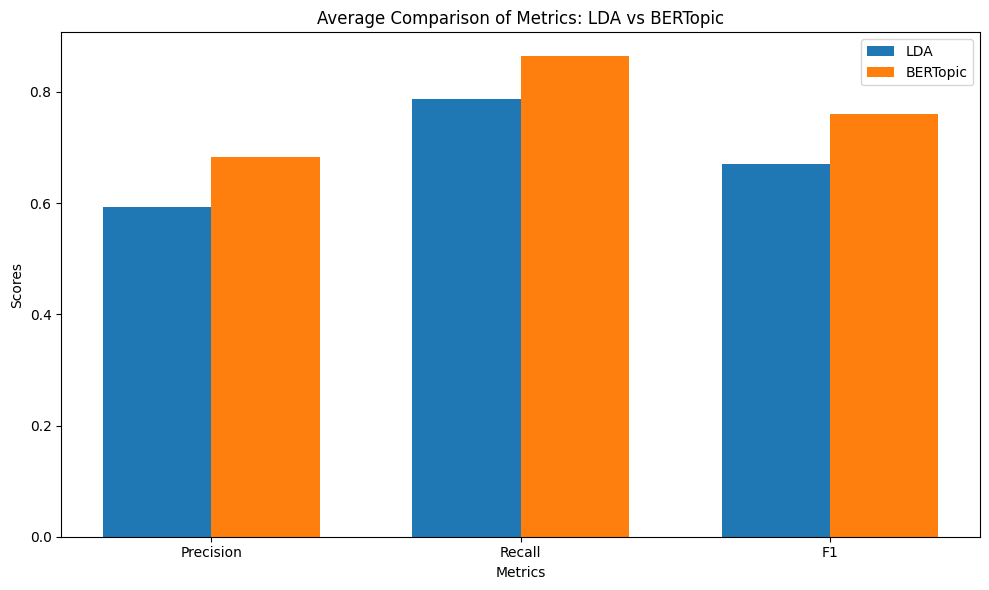

In [220]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated metrics for both LDA and BERTopic models as shown in your provided code

# List of metric names
metrics = ["Precision", "Recall", "F1"]

# Calculate average scores for LDA and BERTopic
avg_lda = [(micro_precision_lda + macro_precision_lda) / 2,
           (micro_recall_lda + macro_recall_lda) / 2,
           (micro_f1_lda + macro_f1_lda) / 2]
avg_bertopic = [(micro_precision + macro_precision) / 2,
                (micro_recall + macro_recall) / 2,
                (micro_f1 + macro_f1) / 2]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

bar1 = plt.bar(index, avg_lda, bar_width, label='LDA')
bar2 = plt.bar(index + bar_width, avg_bertopic, bar_width, label='BERTopic')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Average Comparison of Metrics: LDA vs BERTopic')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

plt.tight_layout()
plt.show()




## Multi-lingual BerTopic model

In [229]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained German BERT-based language model
model_german = SentenceTransformer('distiluse-base-multilingual-cased')

In [230]:
topic_model_german = BERTopic(language='german', embedding_model=model_german)

In [231]:
topics_german,probs_german = topic_model_german.fit_transform(text_data)

In [232]:
# Retrieve topic keywords from the BERTopic model
bertopic_germantopic_keywords =topic_model_german.get_topics()

In [233]:
topic_labelsgerman = topic_model_german.generate_topic_labels(nr_words=5, separator=", ")
type(topic_labelsgerman)
topic_labelsgerman

['-1, nowar, standwithukraine, nowplaying, todayweareallukraine, hahahahahahaha',
 '0, the, to, ukraine, standwithukraine, you',
 '1, stand, with, ukraine, we, from',
 '2, standwithukraine, via, comment, spark, peaceforukraine',
 '3, standwithukraine, stay, defenddemocracy, noflyzone, strong',
 '4, playing, video, standwithukraine, is, now']

In [234]:
topic_labels_german = topic_model_german.generate_topic_labels(nr_words=5, separator=", ")

formatted_topic_labels = []
for label in topic_labels_german:
    parts = label.split(", ")
    formatted_label = [parts[0]]
    formatted_label.extend(parts[1:])
    formatted_topic_labels.append(formatted_label)

print(formatted_topic_labels)



[['-1', 'nowar', 'standwithukraine', 'nowplaying', 'todayweareallukraine', 'hahahahahahaha'], ['0', 'the', 'to', 'ukraine', 'standwithukraine', 'you'], ['1', 'stand', 'with', 'ukraine', 'we', 'from'], ['2', 'standwithukraine', 'via', 'comment', 'spark', 'peaceforukraine'], ['3', 'standwithukraine', 'stay', 'defenddemocracy', 'noflyzone', 'strong'], ['4', 'playing', 'video', 'standwithukraine', 'is', 'now']]


In [235]:
topic_labels_german = topic_model_german.generate_topic_labels(nr_words=5, separator=", ")

formatted_topic_labels = []
for label in topic_labels_german:
    parts = label.split(", ")
    formatted_label = parts[1:]  # Exclude the first element
    formatted_topic_labels.append(formatted_label)

print(formatted_topic_labels)


[['nowar', 'standwithukraine', 'nowplaying', 'todayweareallukraine', 'hahahahahahaha'], ['the', 'to', 'ukraine', 'standwithukraine', 'you'], ['stand', 'with', 'ukraine', 'we', 'from'], ['standwithukraine', 'via', 'comment', 'spark', 'peaceforukraine'], ['standwithukraine', 'stay', 'defenddemocracy', 'noflyzone', 'strong'], ['playing', 'video', 'standwithukraine', 'is', 'now']]


## Precision, Recalla nd F1 of Multi-lingual Bertopic model

In [279]:
metrics_list = []

for idx, transformed_topic in enumerate(formatted_topic_labels, start=1):
    topic_metrics = []
    for unique_topic in unique_manual_labels_list_of_lists:
        true_positive = len(set(transformed_topic).intersection(unique_topic))
        false_positive = len(set(transformed_topic).difference(unique_topic))
        false_negative = len(set(unique_topic).difference(transformed_topic))
        
        if true_positive == 0 and (false_positive == 0 or false_negative == 0):
            precision = recall = f1 = 0  # Handle division by zero
        else:
            precision = true_positive / (true_positive + false_positive)
            recall = true_positive / (true_positive + false_negative)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        topic_metrics.append((precision, recall, f1))
    
    best_metrics = max(topic_metrics, key=lambda x: x[2])  # Choose metrics for the highest F1 score
    metrics_list.append((idx, *best_metrics))

# Calculate maximum column widths for formatting
column_widths = [max(len(str(item)) for item in row) for row in zip(["Topic"] + [f"Topic {idx}" for idx in range(1, len(metrics_list[0][1:]))], *metrics_list)]

# Print the header for precision, recall, and f1
header = ["Topic", "Precision", "Recall", "F1"]
header_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(header, column_widths))
print(header_formatted)

# Print topic metrics for precision, recall, and f1
for idx, *values in metrics_list:
    topic_line = [f"Topic {idx}"] + [f"{value:.2f}" for value in values]
    topic_line_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(topic_line, column_widths))
    print(topic_line_formatted)

# Empty line for separation
print()

# Print the header for f1 scores only
f1_header = ["Topic", "F1"]
f1_header_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(f1_header, column_widths))
print(f1_header_formatted)

# Print topic metrics for f1 scores only
for idx, *values in metrics_list:
    f1_topic_line = [f"Topic {idx}", f"{values[2]:.2f}"]
    f1_topic_line_formatted = "  ".join(f"{col:<{width}}" for col, width in zip(f1_topic_line, column_widths))
    print(f1_topic_line_formatted)


Topic  Precision  Recall 
Topic 1  0.40     0.50   
Topic 2  0.40     0.50   
Topic 3  0.60     0.75   
Topic 4  0.40     1.00   
Topic 5  0.60     1.00   
Topic 6  0.80     1.00   

Topic  F1     
Topic 1  0.44   
Topic 2  0.44   
Topic 3  0.67   
Topic 4  0.57   
Topic 5  0.75   
Topic 6  0.89   


In [283]:
# Initialize variables for micro and macro averages
total_tp = total_fp = total_fn = total_precision = total_recall = total_f1 = 0

# Iterate through the metrics list
for _, precision, recall, f1 in metrics_list:
    total_tp += precision * (precision + recall)
    total_fp += (1 - precision) * recall
    total_fn += (1 - recall) * precision
    total_precision += precision
    total_recall += recall
    total_f1 += f1

# Calculate micro-average
micro_precision = total_tp / (total_tp + total_fp)
micro_recall = total_tp / (total_tp + total_fn)
micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

# Calculate macro-average
num_topics = len(metrics_list)
macro_precision = total_precision / num_topics
macro_recall = total_recall / num_topics
macro_f1 = total_f1 / num_topics

# Print micro and macro averages in a tabular format
print("{:<15} {:<15} {:<15} {:<15}".format("", "Precision", "Recall", "F1"))
print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format("Micro-average:", micro_precision, micro_recall, micro_f1))
print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format("Macro-average:", macro_precision, macro_recall, macro_f1))


                Precision       Recall          F1             
Micro-average:  0.68            0.89            0.77           
Macro-average:  0.53            0.79            0.63           
